In [1]:
import os
import numpy as np
import pandas as pd
import scipy.io

import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interactive
%matplotlib inline

## Load data

In [2]:
meta = pd.read_excel('C:/Users/lan/Documents/repos/inter/mat/adp_dataset_master.xlsx', index_col=None)
meta = meta[meta.seg == 'segmented']
meta = meta[['mouse','date','area']]

In [11]:
nset = len(meta.index); ncell = []; nori = 8; nisi = 3; 
dir_name = 'C:\\Users\\lan\\Documents\\repos\\inter\\mat\\'

vis_driven = np.empty([0,1]); ori_driven = np.empty([0,nori]); ori_driven_cell = np.empty([0,1]);
dfof_tg = np.empty([0,nori,nisi]); dfof_tg_std = dfof_tg; dfof_tg_sem = dfof_tg

for iset in np.arange(nset):
    dir_sub = str(meta.area[iset]) + '_i' + str(meta.mouse[iset]) + '_' + str(meta.date[iset]) + '_ohki'

    cell_prop = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'cell_property.mat'))
    dfof = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'dfof_tg' + '.mat'))
    
    ncell.append(len(cell_prop['vis_driven']))    
    vis_driven = np.concatenate((vis_driven, cell_prop['vis_driven']), axis=0)
    ori_driven = np.concatenate((ori_driven, cell_prop['ori_driven']), axis=0)
    ori_driven_cell = np.concatenate((ori_driven_cell, cell_prop['ori_driven_cell']), axis=0)
    
    dfof_tg = np.concatenate((dfof_tg, dfof['dfof_tg']), axis=0)
    dfof_tg_std = np.concatenate((dfof_tg_std, dfof['dfof_tg_std']), axis=0)
    dfof_tg_sem = np.concatenate((dfof_tg_sem, dfof['dfof_tg_sem']), axis=0)

ncell, vis_driven.shape, ori_driven.shape, ori_driven_cell.shape, dfof_tg.shape, dfof_tg_std.shape, dfof_tg_sem.shape

([97, 69, 53, 103, 39, 33, 93, 52],
 (539, 1),
 (539, 8),
 (539, 1),
 (539, 8, 3),
 (539, 8, 3),
 (539, 8, 3))

In [13]:
meta['ncell'] = ncell
# meta = meta.replace({'area' : { 'V1':1, 'LM':2, 'LI':3 }})
mouse_cell = [item for item, count in zip(meta.mouse, meta.ncell) for i in range(count)]
area_cell = [item for item, count in zip(meta.area, meta.ncell) for i in range(count)]
meta_cell = pd.DataFrame({'mouse': mouse_cell, 'area': area_cell})
meta_cell 

,mouse,area
0,1322,V1
1,1322,V1
2,1322,V1
3,1322,V1
4,1322,V1
...,...,...
534,1324,LM
535,1324,LM
536,1324,LM
537,1324,LM


## Ori responsive distribution
to determine cell selection in training set

In [228]:
df = meta_cell.copy()
df['vis_driven'] = vis_driven.flatten()

attach = pd.DataFrame(columns = ['ori_driven'])
for row in ori_driven:
    temp = pd.DataFrame(columns = ['ori_driven']); temp['ori_driven'] = [row]
    attach = pd.concat([attach, temp])

df2 = pd.concat([df, attach.reset_index()], axis=1)
df2.drop(['index'], axis=1, inplace=True)

df3 = df2.copy()
df3 = df3[df3.vis_driven == 1].reset_index().drop(['index'], axis=1)
df3

,mouse,area,vis_driven,ori_driven
0,1322,V1,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]"
1,1322,V1,1.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,1322,V1,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
3,1322,V1,1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,1322,V1,1.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]"
...,...,...,...,...
353,1324,V1,1.0,"[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
354,1324,LM,1.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
355,1324,LM,1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0]"
356,1324,LM,1.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]"


In [197]:
ori_driven_area = np.empty([len(np.unique(df3.area)), nori]); iarea = 0
for area in np.unique(df3.area):
    df_area = df3[df3.area == area]
    df_area = df_area.reset_index()
    t = df_area['ori_driven'].to_numpy()
    t = np.concatenate(t).ravel().reshape([-1, nori])
    ori_driven_area[iarea,:] = np.sum(t, axis=0)
    iarea += 1
np.unique(df3.area), ori_driven_area

(array(['LI', 'LM', 'V1'], dtype=object),
 array([[ 8., 14., 14., 14., 21., 25., 14., 12.],
        [27., 20., 26., 24., 27., 28., 28., 27.],
        [54., 37., 55., 27., 45., 54., 60., 80.]]))

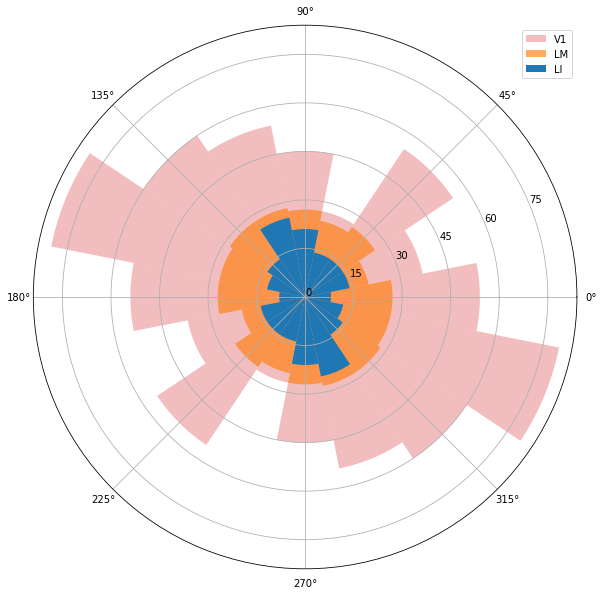

In [217]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection='polar')
N = nori * 2
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
width = np.pi / nori
color_list = ['C0', 'C1', 'C3']

for i in np.flip(np.arange(len(np.unique(df3.area)))):
    y = np.concatenate((ori_driven_area[i], ori_driven_area[i]))
    ax.bar(theta, y, width=width, bottom=0.0, color=color_list[i], alpha=1-0.35*i)

plt.yticks(np.arange(0, 90, step=15))
ax.legend(['V1', 'LM', 'LI'])
plt.show()

In [230]:
df2.tail()

,mouse,area,vis_driven,ori_driven
534,1324,LM,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
535,1324,LM,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
536,1324,LM,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
537,1324,LM,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
538,1324,LM,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [237]:
df.groupby(['area','mouse']).describe()

vis_driven                                             
                count      mean       std  min  25%  50%  75%  max
area mouse                                                        
LI   1322        53.0  0.603774  0.493793  0.0  0.0  1.0  1.0  1.0
     1323        33.0  0.727273  0.452267  0.0  0.0  1.0  1.0  1.0
LM   1322        69.0  0.811594  0.393901  0.0  1.0  1.0  1.0  1.0
     1323        39.0  0.641026  0.485971  0.0  0.0  1.0  1.0  1.0
     1324        52.0  0.076923  0.269069  0.0  0.0  0.0  0.0  1.0
V1   1322        97.0  0.917526  0.276515  0.0  1.0  1.0  1.0  1.0
     1323       103.0  0.446602  0.499571  0.0  0.0  0.0  1.0  1.0
     1324        93.0  0.881720  0.324689  0.0  1.0  1.0  1.0  1.0

In [239]:
df[['area','vis_driven']].groupby('area').describe()

vis_driven                                             
          count      mean       std  min  25%  50%  75%  max
area                                                        
LI         86.0  0.651163  0.479398  0.0  0.0  1.0  1.0  1.0
LM        160.0  0.531250  0.500589  0.0  0.0  1.0  1.0  1.0
V1        293.0  0.740614  0.439047  0.0  0.0  1.0  1.0  1.0